# Profile Based Information Retrieval System
### Carlos Alcoba, Javier Jiménez, Javier Pozo

## Install and import libraries

In [1]:
# pip install -r requirements.txt

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [2]:
#for dataframes and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#other libraries
import random

## Import the dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [4]:
# Create a dataframe
data = pd.read_csv('20_newsgroup.csv', index_col = 0)

# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-08 15:42:05.152950
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-08 15:42:05.152950
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-08 15:42:05.152950
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-08 15:42:05.152950
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-08 15:42:05.152950


In [5]:
#Split the dataset into training and testing ones
df_train, df_test = train_test_split(data,test_size=0.1,shuffle=True, random_state=1)

## Exploratory data analysis

rec.sport.baseball    905
sci.med               892
rec.autos             886
talk.politics.misc    686
talk.religion.misc    570
Name: title, dtype: int64


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Number of douments in each class')]

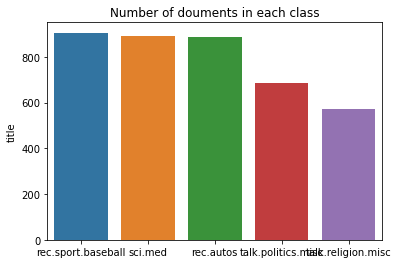

In [6]:
#Count the number of douments in each class
x=df_train['title'].value_counts()
print(x)
sns.barplot(x.index,x).set(title="Number of douments in each class")

In [7]:
# Find NaN values
df_test.isna().sum()

text      15
target     0
title      0
date       0
dtype: int64

In [8]:
# Drop NaN values
df_train = df_train.dropna()
df_test = df_test.dropna()
# Check for it
df_test.isna().sum()

text      0
target    0
title     0
date      0
dtype: int64

In [9]:
# Some word count examples
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==9]['word_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['word_count'].mean()) # Baseball posts

129.75512528473803
116.2840909090909


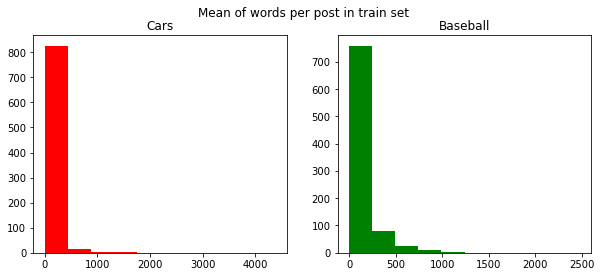

In [10]:
# Some Word-Count plots examples
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Mean of words per post in train set')
plt.show()

In [11]:
# Some character count examplesS
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['char_count'].mean()) # Baseball posts


753.5956719817767
664.1818181818181


## Text processing

In [12]:
# Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Remove Stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Lemmatize:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [13]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Obtain clean text columns
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))


In [14]:
# Obtain final train and test vectors 
X_train, y_train = df_train["clean_text"], df_train["title"]
X_test, y_test = df_test["clean_text"], df_test["title"]


# Tokenize sentences to future applications
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

## Text vectorizers

In [15]:
#TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
#Obtain vectors via TF-IDF
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
# Doc2Vec vectorizer
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [17]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [18]:
# Obtain vectors via doc2vec
y_train_w2v, x_train_w2v = vec_for_learning(model, train_docs)


## Train best model found from models.ipynb

In [19]:
X_train_vectors_tfidf = X_train_vectors_tfidf.toarray()
X_test_vectors_tfidf = X_test_vectors_tfidf.toarray()

In [20]:
from keras import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [21]:
# one hot encode
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = tf.keras.utils.to_categorical(encoder.transform(y_train))
y_test = tf.keras.utils.to_categorical(encoder.transform(y_test))

In [22]:
encoder.classes_

array(['rec.autos', 'rec.sport.baseball', 'sci.med', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [23]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17372533280547421278
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6273040384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8599422834133797641
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [24]:
model = Sequential()
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 512
history = model.fit(X_train_vectors_tfidf, y_train,
                    epochs=20, batch_size=batch_size, validation_data=(X_test_vectors_tfidf, y_test), verbose=0)
#Predict y value for test dataset
y_predict = model.predict(X_test_vectors_tfidf)
print(classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
print('Confusion Matrix:\n',confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1)))

acc = accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
f1 = f1_score(y_test.argmax(axis=1), y_predict.argmax(axis=1), average ='weighted')

print(f"Test Accuracy of Neural Network(tf-idf) is {acc} \n")

print(f"Test F1-score weighted of Neural Network(tf-idf) is {f1} \n")

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       100
           1       0.90      0.93      0.92        88
           2       0.97      0.97      0.97        95
           3       0.88      0.91      0.89        86
           4       0.86      0.78      0.82        54

    accuracy                           0.92       423
   macro avg       0.91      0.90      0.91       423
weighted avg       0.92      0.92      0.92       423

Confusion Matrix:
 [[94  2  1  2  1]
 [ 2 82  1  2  1]
 [ 0  1 92  1  1]
 [ 1  3  0 78  4]
 [ 2  3  1  6 42]]
Test Accuracy of Neural Network(tf-idf) is 0.91725768321513 

Test F1-score weighted of Neural Network(tf-idf) is 0.9167842842254871 



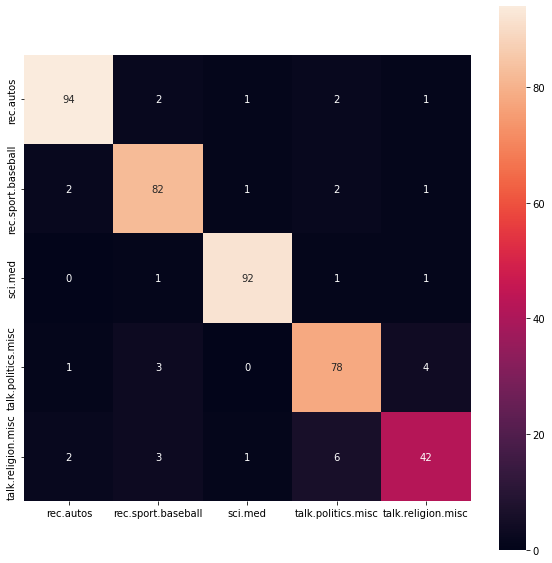

In [25]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(matrix,annot=True, square = True, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.savefig("confusion_matrix.jpg")
plt.show()

## Define toy set of users

In [26]:
# Associate targets with interests
interests = ["autos", "baseball", "medicine", "politics", "religion"]

def generate_users(n_user, interests= ["autos", "baseball", "medicine", "politics", "religion"]):
    users = {}
    for user in range(n_user):
        n_interest = random.randint(1, 3)
        user_interest = []
        i = random.sample(range(0,4), n_interest)
        user_interest.append([interests[e] for e in i])
            
        users[user] = user_interest
    return users

In [27]:
# Generate users
users = generate_users(10, interests=encoder.classes_)

In [28]:
# Predict the type of the query text using the best classifier
pred = model.predict(np.array( [X_test_vectors_tfidf[50],] ))

# function that automatically assigns texts for users
def assigne_text(users, pred):
    if pred == 0:
        text = 'autos'
    elif pred == 1:
        text = 'baseball'
    elif pred == 2:
        text = 'medicine'
    elif pred == 3:
        text = 'politics'
    else:
        text = 'religion'
    assigned = []
    for user, interest in users.items():
        if text[:3] in interest[0][0]:
            assigned.append(user)
            
    return assigned, text.upper()

In [29]:
assigned, text_topic = assigne_text(users, int(np.argmax(pred)))
for user in assigned:
    print("This text is assigned to user {}. It is a {} text.".format(user, text_topic))

This text is assigned to user 4. It is a MEDICINE text.
This text is assigned to user 7. It is a MEDICINE text.


In [30]:
classify = True
while classify:
    print('Welcome to text classifcation and assignation tool!')
    print('-------------------------------------')
    print('-------------------------------------')
    text_to_predict = input('       Please enter the text to classify and deliver to a user or enter 2 to leave: ')
    if text_to_predict == '2':
        classify = False
        print()
        print('Thanks for using!!')
        print('-------------------------------------')
        print('-------------------------------------')
    else:
        clean_predict = finalpreprocess(text_to_predict)
        to_predict = tfidf_vectorizer.transform([clean_predict]).toarray()
        pred = model.predict(np.array(to_predict))
        assigned, text_topic = assigne_text(users, int(np.argmax(pred)))
        print()
        print()
        print('-------------------------------------')
        if assigned:
            for user in assigned:
                print("This text is assigned to user {}. It is a {} text.".format(user, text_topic))
        else:
            print('No user has interest in topic {}'.format(text_topic))
        print('-------------------------------------')
        print()
        print()

Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  Well, looking at the videos it seems that this fire started in various places at the same time, which would indicate that this was a planned action. I'm sure FBI and BATF didn't *deliberately* start a possible fire, having a sniper kill Korresh would have been a far easier  method. Looking at the careful operation, and use of tear gas that as I know don't start fires, it is less likely that this  was the case.  Sorry, but my bets are on fanatical people keen to start Armageddon -- theirs.  Cheers, Kent




-------------------------------------
No user has interest in topic RELIGION
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  This is very curious being that they are both built by Mercury in the very same factory.  Steve




-------------------------------------
This text is assigned to user 2. It is a AUTOS text.
This text is assigned to user 3. It is a AUTOS text.
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  It's not a cliche, and (unlike your comments below) it's not a tautology. It needn't have been true.  If every pitcher in baseball were essentially the same in quality (i.e. if the variance of pitching ability were much smaller than the variance of batting ability), then scoring runs would be much more important than preventing them, simply because the *ability* to actively prevent runs would be much weaker.   If that's your point, you should have said so.  What you in fact said was "Pitching and defense win championships", and later "Pitching is the essence of baseball".  Neither of which says what you are now claiming was "your  point", and neither of which is true.   And you accuse Sherri of mouthing cliches!?   It's not clear to me at all that this is true.  In high-scoring games, the team with the better offense wins a high percentage of the time.  In low- scoring games, the split is essentially 5



-------------------------------------
This text is assigned to user 6. It is a BASEBALL text.
This text is assigned to user 8. It is a BASEBALL text.
This text is assigned to user 9. It is a BASEBALL text.
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  I'm really surprised Clinton hasn't already tried to do this.  He seems to want to tackle other irrelevant issues first, so why not this one as well.   Wrong.  We need its capability.  Sure it has its problems, very few airplanes haven't, but getting rid of something we need is not the answer.  What do you want to do, start over a rebuild a new airplane from scatch?  It'll have its problems as well and there will be calls again, for it to be scrapped.  THe other option is to try to extend the life of the C-5s and C-141s that are getting extremely old.   It'll cost jobs, but I'm for it.  We especially don't need a B-2. THe SSN-21, I know litttle about.




-------------------------------------
This text is assigned to user 0. It is a POLITICS text.
This text is assigned to user 1. It is a POLITICS text.
This text is assigned to user 5. It is a POLITICS text.
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  That will make it easy for a car thief. Saves him/her the trouble of popping your ignition!




-------------------------------------
This text is assigned to user 2. It is a AUTOS text.
This text is assigned to user 3. It is a AUTOS text.
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:      Do you swim nude in a public swimming pool?  :)  I doubt sperm can penetrate swimsuit material, assuming they aren't immediately dispersed by water currents.




-------------------------------------
This text is assigned to user 4. It is a MEDICINE text.
This text is assigned to user 7. It is a MEDICINE text.
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  One should be aware that foreign doctors admitted for training are ineligible to apply for resident alien status.  In order to get the green card they have to return to their country and apply at the embassy there.  Of course, many somehow get around this problem.  Often it is by agreeing to practice in a town with a need and then the congressman from that district tacks a rider onto a bill saying "Dr. X will be allowed to have permanent residency in the US."  A lot of bills in congress have such riders attached to them.  Marrying a US citizen is the most common, although now they are even cracking down on that and trying to tell US citizens they must follow their spouse back to the Phillipines, or whereever.    --  ---------------------------------------------------------------------------- Gordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and geb@cadre.dsl.pitt.edu   |  it is s



-------------------------------------
This text is assigned to user 4. It is a MEDICINE text.
This text is assigned to user 7. It is a MEDICINE text.
-------------------------------------


Welcome to text classifcation and assignation tool!
-------------------------------------
-------------------------------------


       Please enter the text to classify and deliver to a user or enter 2 to leave:  2



Thanks for using!!
-------------------------------------
-------------------------------------
